In [1]:
!pip install scanpy
!pip install -i https://test.pypi.org/simple/ "scikit-misc==0.2.0rc1"
!pip install scvi-tools
!pip install anndata

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.2 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=c79d4205f298fc4796078b8c6d8a4d8505e2ccb543e93e59149246af788d9b04
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
Looking in indexes: https://test.pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir /content/Extracted

In [4]:
!unzip /content/drive/MyDrive/Yeehaw_datasets/GSE114615.zip -d /content/Extracted

Archive:  /content/drive/MyDrive/Yeehaw_datasets/GSE114615.zip
   creating: /content/Extracted/GSE114615/
  inflating: /content/Extracted/GSE114615/GSM3145909.txt  
  inflating: /content/Extracted/GSE114615/GSM3145911.txt  
  inflating: /content/Extracted/GSE114615/GSM3145910.txt  
  inflating: /content/Extracted/GSE114615/GSM3145908.txt  
  inflating: /content/Extracted/GSE114615/GSM3145906.txt  
  inflating: /content/Extracted/GSE114615/GSM3145907.txt  


In [87]:
import pandas as pd
import scanpy as sc

# Load the data
df = pd.read_csv('/content/Extracted/GSE114615/GSM3145906.txt')

# Extract gene identifiers (first column)
gene_identifier = df.iloc[:, 0].values  # Extract as a NumPy array for proper indexing

# Drop the first column (gene identifiers) from the DataFrame
df.drop(df.columns[0], axis=1, inplace=True)

# Initialize the AnnData object with transposed DataFrame
adata = sc.AnnData(df.transpose())

# Set the correct gene names (var_names) and cell names (obs_names)
adata.var_names = gene_identifier
adata.obs_names = df.columns

# Ensure that the data matrix is in float32 format
adata.X = adata.X.astype('float32')

# Check the AnnData object structure
print(adata)

AnnData object with n_obs × n_vars = 199 × 23015


/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [88]:
# Check the first few gene names
print("Gene names (var_names):", adata.var_names[:10])

# Check for any duplicated gene names
if adata.var_names.duplicated().any():
    print("Duplicated gene names found. Making unique.")
    adata.var_names_make_unique()


Gene names (var_names): Index(['AT1G01010', 'AT1G01020', 'AT1G01030', 'AT1G01040', 'AT1G01050',
       'AT1G01060', 'AT1G01070', 'AT1G01080', 'AT1G01090', 'AT1G01100'],
      dtype='object')


In [89]:
gene_identifier

array(['AT1G01010', 'AT1G01020', 'AT1G01030', ..., 'ATMG01380',
       'ATMG01390', 'ATMG09740'], dtype=object)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 199 × 23015

In [90]:
adata.X

array([[ 3.,  1.,  0., ...,  2., 18.,  0.],
       [ 5.,  1.,  0., ...,  3., 34.,  0.],
       [ 2.,  2.,  0., ...,  2., 20.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  4.,  0.]], dtype=float32)

In [91]:
adata.var.shape

(23015, 0)

In [92]:

import scanpy as sc


sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


adata.var['mt'] = adata.var.index.str.contains('^MT-')
mito_prefixes = ['nad', 'nd', 'cox', 'atp', 'cob', 'rrn', 'rps', 'rpl', 'matR', 'mttB']

adata.var['mt'] = adata.var.index.str.contains('|'.join(mito_prefixes))

print(f"Number of mitochondrial genes: {adata.var['mt'].sum()}")



Number of mitochondrial genes: 0


In [93]:
import scipy.sparse as sp

if sp.issparse(adata.X):
    print("adata.X is a sparse matrix")
else:
    print("adata.X is a dense matrix")


adata.X is a dense matrix


In [94]:
import numpy as np


adata.obs['n_genes'] = np.array(adata.X.sum(axis=1)).flatten()
adata.obs['n_counts'] = np.array(adata.X.sum(axis=1)).flatten()


adata.obs['mt_frac'] = (
    np.array(adata[:, adata.var['mt']].X.sum(axis=1)).flatten() / adata.obs['n_counts']
)
adata = adata[adata.obs['mt_frac'] < 0.1]

In [95]:
import numpy as np


gene_count_threshold = np.percentile(adata.obs['n_genes'], 95)
umi_count_threshold = np.percentile(adata.obs['n_counts'], 95)


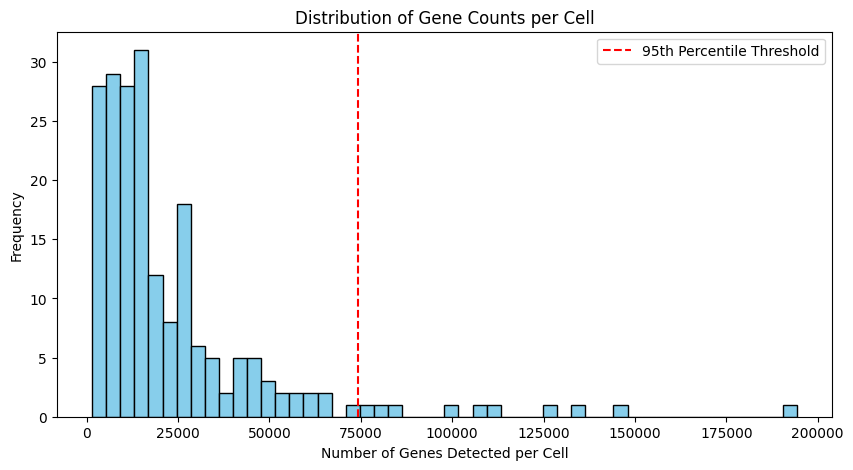

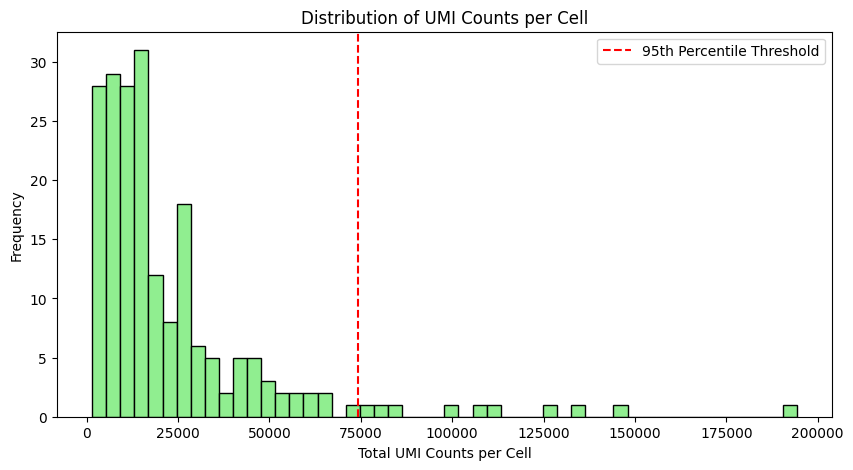

In [96]:
import matplotlib.pyplot as plt
# Plot histogram for gene counts
plt.figure(figsize=(10, 5))
plt.hist(adata.obs['n_genes'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(gene_count_threshold, color='red', linestyle='--', label='95th Percentile Threshold')
plt.xlabel('Number of Genes Detected per Cell')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Counts per Cell')
plt.legend()
plt.show()

# Plot histogram for UMI counts
plt.figure(figsize=(10, 5))
plt.hist(adata.obs['n_counts'], bins=50, color='lightgreen', edgecolor='black')
plt.axvline(umi_count_threshold, color='red', linestyle='--', label='95th Percentile Threshold')
plt.xlabel('Total UMI Counts per Cell')
plt.ylabel('Frequency')
plt.title('Distribution of UMI Counts per Cell')
plt.legend()
plt.show()

In [97]:
from scipy.stats import percentileofscore

percentile_gene = percentileofscore(adata.obs['n_genes'], 50000)
percentile_UMI = percentileofscore(adata.obs['n_counts'], 50000)

print(f"50,000 gene counts correspond to the {percentile_gene:.2f}th percentile.")
print(f"50,000 gene counts correspond to the {percentile_UMI:.2f}th percentile.")

50,000 gene counts correspond to the 89.95th percentile.
50,000 gene counts correspond to the 89.95th percentile.


In [98]:
adata.obs['predicted_doublet'] = (
    (adata.obs['n_genes'] > 50000) |
    (adata.obs['n_counts'] > 50000)
)


adata = adata[~adata.obs['predicted_doublet']]

<ipython-input-98-4a11265b0794>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['predicted_doublet'] = (


In [99]:

adata.var['ribosomal'] = adata.var.index.str.contains('^RPS|^RPL')

print(f"Number of ribosomal genes identified: {adata.var['ribosomal'].sum()}")


Number of ribosomal genes identified: 0


<ipython-input-99-81ae5b0351ac>:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ribosomal'] = adata.var.index.str.contains('^RPS|^RPL')


In [100]:
import pandas as pd


ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)

ribo_gene_list = ribo_genes[0].tolist()

adata.var['ribosomal'] = adata.var.index.isin(ribo_gene_list)

print(f"Number of ribosomal genes identified: {adata.var['ribosomal'].sum()}")


Number of ribosomal genes identified: 0


In [101]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]

print(f"Number of highly variable genes selected: {adata.shape[1]}")

Number of highly variable genes selected: 2000


In [102]:
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [103]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip3 install --quiet leidenalg
!pip install --quiet louvain scanpy
!pip install --quiet kb-python

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


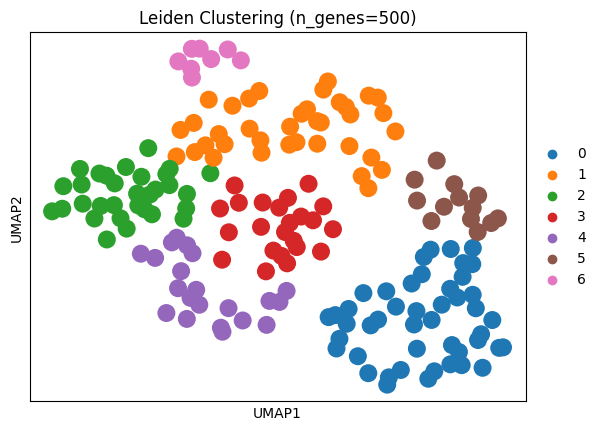

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


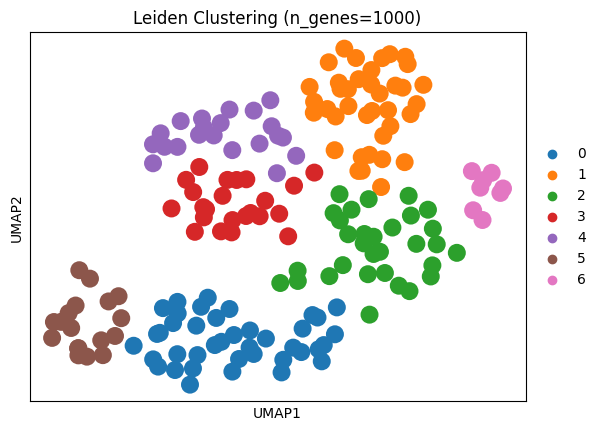

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


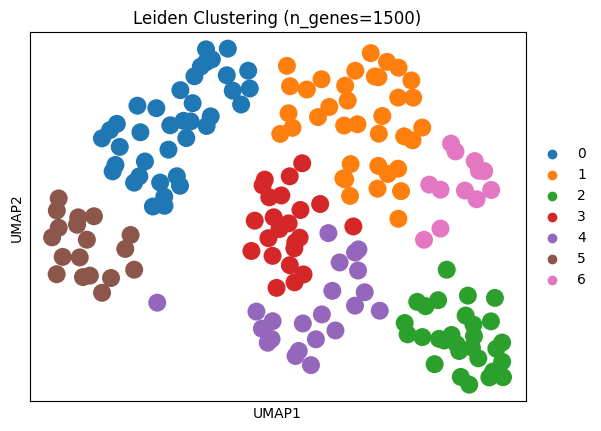

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


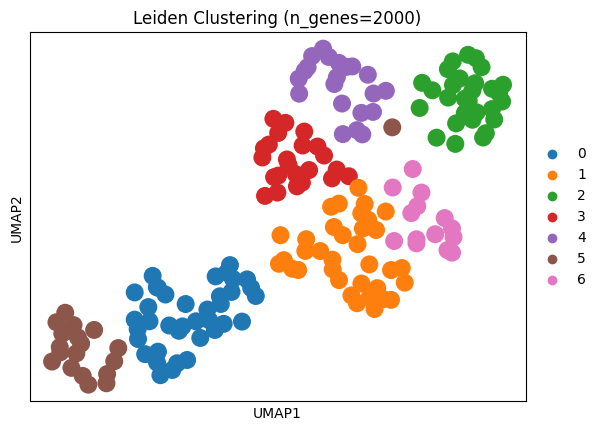

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


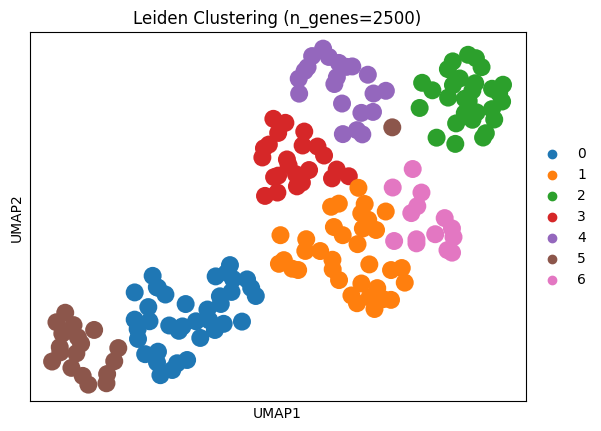

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


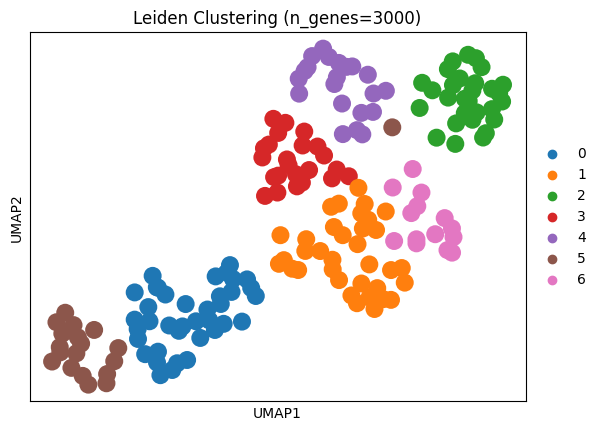

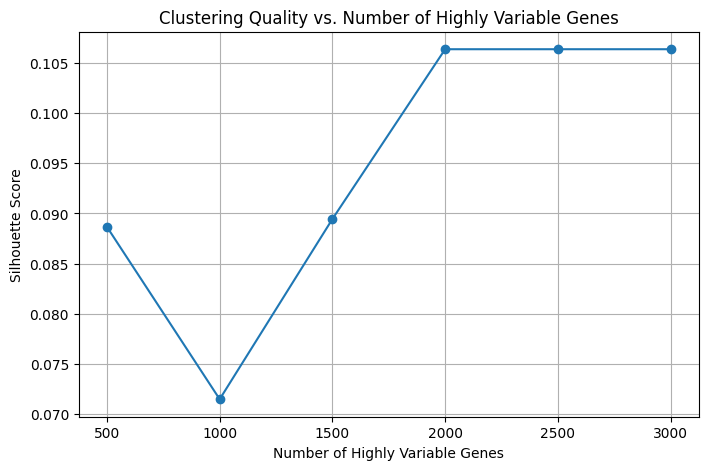

In [104]:
from sklearn.metrics import silhouette_score

n_genes_list = [500, 1000, 1500, 2000, 2500, 3000]
silhouette_scores = []

for n_genes in n_genes_list:
    sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)
    adata_subset = adata[:, adata.var['highly_variable']]
    sc.tl.pca(adata_subset, svd_solver='arpack')
    sc.pp.neighbors(adata_subset)
    sc.tl.leiden(adata_subset)
    sc.tl.umap(adata_subset)
    sc.pl.umap(adata_subset, color='leiden', title=f'Leiden Clustering (n_genes={n_genes})')
    score = silhouette_score(adata_subset.obsm['X_pca'], adata_subset.obs['leiden'])
    silhouette_scores.append(score)

# Plot silhouette score vs. number of HVGs
plt.figure(figsize=(8, 5))
plt.plot(n_genes_list, silhouette_scores, marker='o')
plt.xlabel('Number of Highly Variable Genes')
plt.ylabel('Silhouette Score')
plt.title('Clustering Quality vs. Number of Highly Variable Genes')
plt.grid()
plt.show()


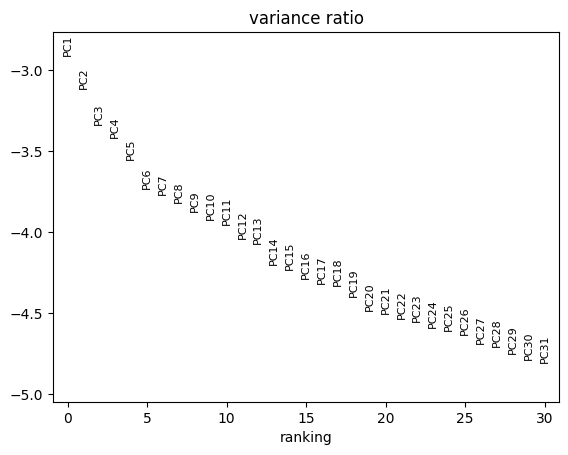

In [112]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

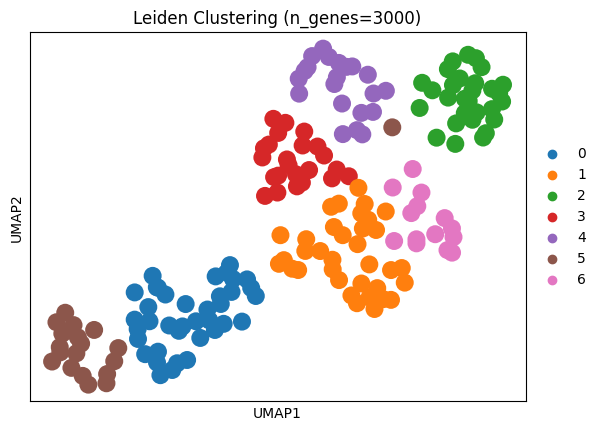

In [114]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', title=f'Leiden Clustering (n_genes={n_genes})')

In [115]:
print(f"Number of cells: {adata.shape[0]}")
print(f"Number of genes: {adata.shape[1]}")


Number of cells: 179
Number of genes: 2000


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

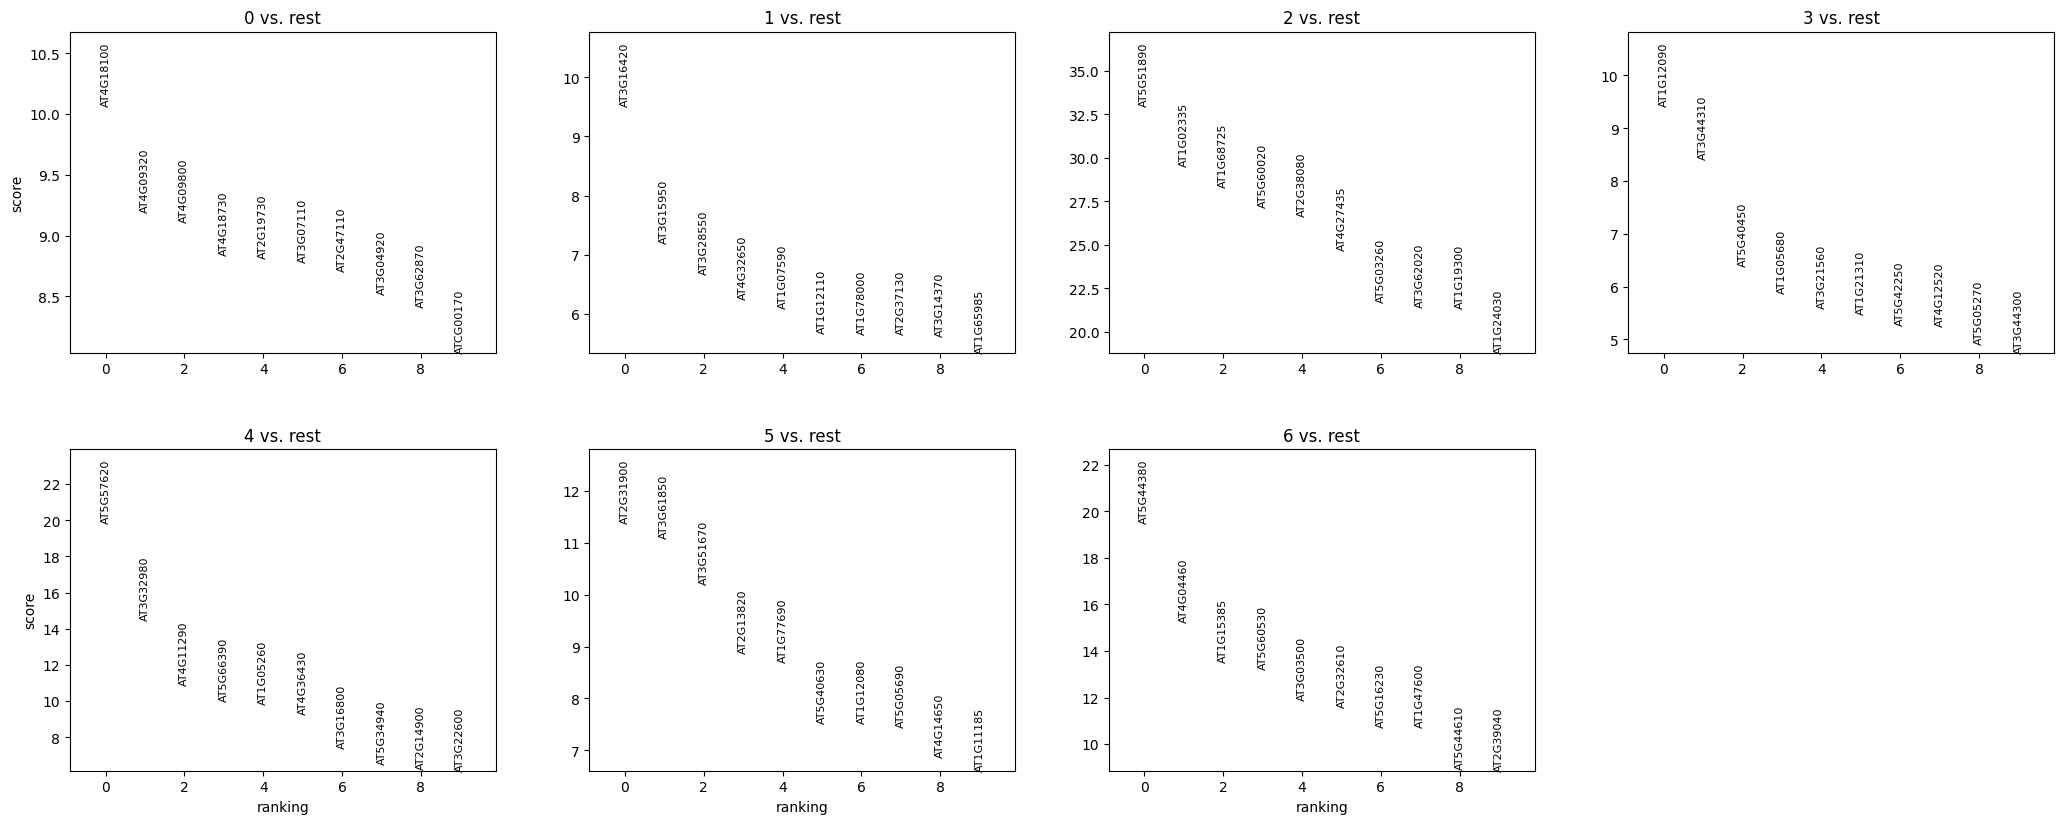

In [116]:
import scanpy as sc

sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)


In [117]:
for cluster in adata.obs['leiden'].cat.categories:
    print(f"Top genes for cluster {cluster}:")
    print(adata.uns['rank_genes_groups']['names'][cluster][:])


Top genes for cluster 0:
['AT4G18100' 'AT4G09320' 'AT4G09800' ... 'AT2G34790' 'AT3G62020'
 'AT4G12910']
Top genes for cluster 1:
['AT3G16420' 'AT3G15950' 'AT3G28550' ... 'AT5G60020' 'AT3G61850'
 'AT3G44310']
Top genes for cluster 2:
['AT5G51890' 'AT1G02335' 'AT1G68725' ... 'AT5G05270' 'AT2G40510'
 'AT4G09800']
Top genes for cluster 3:
['AT1G12090' 'AT3G44310' 'AT5G40450' ... 'AT2G02130' 'AT4G26010'
 'AT2G13820']
Top genes for cluster 4:
['AT5G57620' 'AT3G32980' 'AT4G11290' ... 'AT5G59845' 'AT2G41380'
 'AT3G49220']
Top genes for cluster 5:
['AT2G31900' 'AT3G61850' 'AT3G51670' ... 'AT3G13435' 'AT5G62180'
 'AT1G03850']
Top genes for cluster 6:
['AT5G44380' 'AT4G04460' 'AT1G15385' ... 'AT5G25460' 'AT2G01020'
 'AT5G66420']


In [111]:
print(adata.var.head())

           n_cells     mt  ribosomal  highly_variable     means  dispersions  \
AT1G01070       18  False      False            False  2.412645     6.483997   
AT1G01380       19  False      False             True  2.314052     6.731840   
AT1G01660       24  False      False             True  2.776446     7.618859   
AT1G01670       19  False      False             True  3.520019     8.569893   
AT1G01680       30  False      False             True  1.694413     5.992649   

           dispersions_norm      mean       std  
AT1G01070         -1.149113  0.074360  0.307632  
AT1G01380          0.688598  0.068665  0.250415  
AT1G01660          0.451256  0.063351  0.237689  
AT1G01670          0.632970  0.058808  0.237542  
AT1G01680          1.084048  0.138871  0.391265  


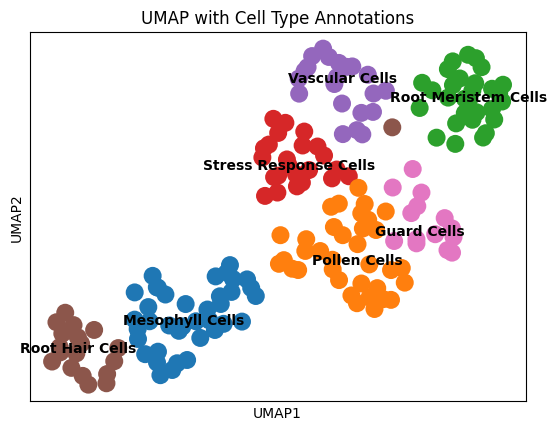

In [118]:
cluster_labels = {
    '0': 'Mesophyll Cells',
    '1': 'Pollen Cells',
    '2': 'Root Meristem Cells',
    '3': 'Stress Response Cells',
    '4': 'Vascular Cells',
    '5': 'Root Hair Cells',
    '6': 'Guard Cells'
}


adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_labels)

sc.pl.umap(adata, color='cell_type', title='UMAP with Cell Type Annotations', legend_loc='on data')


Heatmap for better visualization

In [119]:

top_genes = []
for cluster in adata.obs['leiden'].cat.categories:
    genes = adata.uns['rank_genes_groups']['names'][cluster][:5]
    top_genes.extend(genes)


top_genes = list(set(top_genes))

print(f"Number of unique top marker genes selected: {len(top_genes)}")
print(top_genes[:10])


Number of unique top marker genes selected: 35
['AT4G09800', 'AT3G61850', 'AT3G32980', 'AT3G15950', 'AT2G19730', 'AT3G28550', 'AT3G21560', 'AT5G44380', 'AT5G60530', 'AT2G31900']


In [120]:

top_genes = [gene for gene in top_genes if gene in adata.var_names]

print(f"Number of top marker genes present in the dataset: {len(top_genes)}")



Number of top marker genes present in the dataset: 35


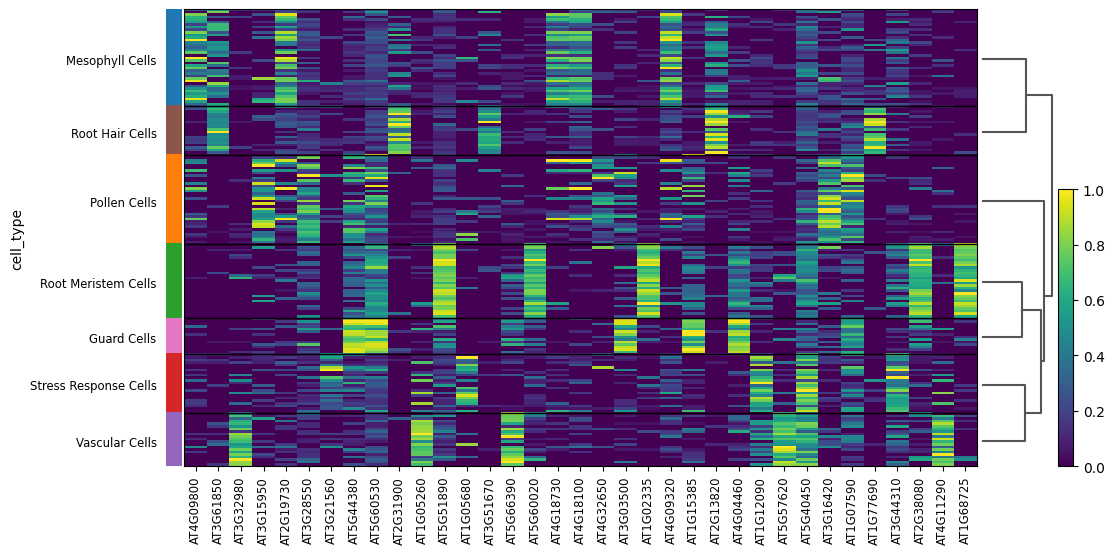

In [121]:
import scanpy as sc


sc.pl.heatmap(
    adata,
    var_names=top_genes,
    groupby='cell_type',
    standard_scale='var',
    cmap='viridis',
    show_gene_labels=True,
    dendrogram=True
)


In [123]:
adata.write('/content/drive/MyDrive/Yeehaw_datasets/final_annotated_data.h5ad')
